# Calculating Atomic Contributions for Molecules Based on Graph Convolutional  QSAR Model. A tutorial. 
<img src="atomic_contributions_tutorial_data/index.png">

## Why do the DeepChem Tutorial?
###  You will learn   to find atoms of molecules important for the activity, and visualize them. We will learn on two tasks: classification and regression.
###  Contributions are also known as "attributions" , "coloration" etc. in literature. Atomic contributions are  defined as the difference in activity of the whole molecule and fragment remaining after atom removal. This is one of model interpretation methods [1], analogous to Similarity maps [2] in QSAR domain, or occlusion methods in other fields (image classification etc).



#### Mariia Matveieva, Pavel Polishchuk. Institute of Molecular and Translational Medicine, Palacky University, Olomouc, Czech Republic.


In [6]:
import pandas as pd
import deepchem as dc
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import tensorflow as tf

## 1. First, let's build a classification QSAR model for Blood-brain barrier permeability
### BBB permeabilty is the ability of compounds to  enter  central nervous system. Here we use dataset of relatively small  compounds which are transported by diffusion without any  carrieers.  The property is defined as log10 (concentration in brain / concentration in blood). Compounds with positive  value (and 0) are labaled active, others inactive.  After modelling we will identify atoms favourable and unfavorable for diffusion.

In [ ]:
# 1. Create dataset

In [7]:
DATASET_FILE ='atomic_contributions_tutorial_data/logBB.sdf'

In [9]:
# create RDKit mol objects, we will need them later
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None ]

In [10]:
len(mols)

298

In [11]:
# loader = dc.data.SDFLoader(tasks=["p_np"], 
loader = dc.data.SDFLoader(tasks=["logBB_class"], 

                           featurizer=dc.feat.ConvMolFeaturizer(),
                           sanitize = True)

dataset = loader.create_dataset(DATASET_FILE, shard_size=2000)



In [12]:
dataset.X.shape

(298,)

In [13]:
# 2. Build a model

In [14]:
np.random.seed(2020)
tf.random.set_seed(2020)

In [15]:
m = dc.models.GraphConvModel(1, mode="classification", nb_epoch=10,batch_normalize=False, restore=False)
m.fit(dataset)


/home/maria/anaconda3/envs/deepchem_testing/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.5348200480143229

In [ ]:
# 3. Test set performance

In [16]:
TEST_DATASET_FILE = 'atomic_contributions_tutorial_data/logBB_test_.sdf'
loader = dc.data.SDFLoader(tasks=["p_np"], sanitize= True,
                           featurizer=dc.feat.ConvMolFeaturizer())

test_dataset = loader.create_dataset(TEST_DATASET_FILE, shard_size=2000)



In [17]:
pred =  m.predict(test_dataset)

In [18]:
pred = np.argmax(np.squeeze(pred),axis= 1)

In [19]:
ba = metrics.balanced_accuracy_score(y_true=test_dataset.y, y_pred=pred)

In [20]:
# balanced accuracy is high enough to procced to model interpretation - i.e. atomic contributions
ba 

0.7444444444444445

## 2. Now, let's prepare dataset of fragments based on training set (any other unseen data set of interest can be used). These fragments will be used to evaluate cotributions of atoms.
### For each molecule we will generate a list of ConvMol objects: featurizations for single atom-depleted versions of the  molecule (iterate over all heavy atoms in the molecule)
### All we need is to load again the training set using standard Deepchem functionality,  but when featurizing it,  set
##### per_atom_fragmentation=True

In [22]:
loader = dc.data.SDFLoader(tasks=[],# dont need task
                        featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True),
                        sanitize=True) 

frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

/home/maria/anaconda3/envs/deepchem_testing/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [23]:
# dataset has much more rows  than original training set, 
# because each row is a fragment of some  molecule. 
# Molecules go in the same order as  original input file. 
# IMPORTANT: fragments order depends on input format: if sdf, then fragment order is the same, as atom order in corresponding mol blocks
# if SMILES (i.e. csv with moecules represented as SMILES), then order is given by RDKit CanonicalRankAtoms

frag_dataset.X.shape

(5111,)

In [24]:
frag_dataset.ids# ids indicate fragment name, all fragments of one molecule have the same name

array(['CC(Cl)(Cl)Cl', 'CC(Cl)(Cl)Cl', 'CC(Cl)(Cl)Cl', ...,
       'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1',
       'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1',
       'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(=O)CO)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1'],
      dtype=object)

## 3. Now we will predict the activity for  molecules and for their fragments. Then, for each fragment,  we'll find the activity difference - that is atomic contribution of removed atom, corresponding to that fragment.
### Note: here, in classification context,  we use probabilistic output of the model as the activity. So, contribution is probability difference, i.e. "how much a given atom increases/decreases the probability of the molecule to be active"

In [25]:
# whole  molecules
pred = np.squeeze(m.predict(dataset))[:, 1] # probabilitiy of class 1
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convinience

In [26]:
# fragments
pred_frags =np.squeeze(m.predict(frag_dataset))[:, 1]
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])

# 4.  Lets finally find atomic contributions:

In [27]:
# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

In [28]:
df

,Fragment,Molecule,Contrib
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.756531,0.811546,0.055015
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.752750,0.811546,0.058796
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.747007,0.811546,0.064539
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.815875,0.811546,-0.004329
C#CC1(O)CCC2C3C(C)CC4=C(CCC(=O)C4)C3CCC21C,0.741801,0.811546,0.069745
...,...,...,...
c1cncc(C2CCCN2)c1,0.780478,0.813036,0.032558
c1cncc(C2CCCN2)c1,0.722650,0.813036,0.090386
c1cncc(C2CCCN2)c1,0.721609,0.813036,0.091427
c1cncc(C2CCCN2)c1,0.683302,0.813036,0.129734


#  5. Visualize contributions with RDKit Similarity Maps

In [29]:
def vis_contribs(mols, df, smi_or_sdf = "sdf"): 
    # input format of file, which was used to create dataset  determines the order of atoms, 
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]
        if smi_or_sdf == "sdf":        
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt))
    return maps    

### Let's look at some pictures:

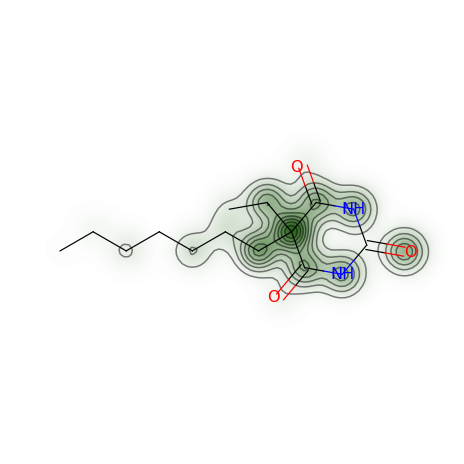

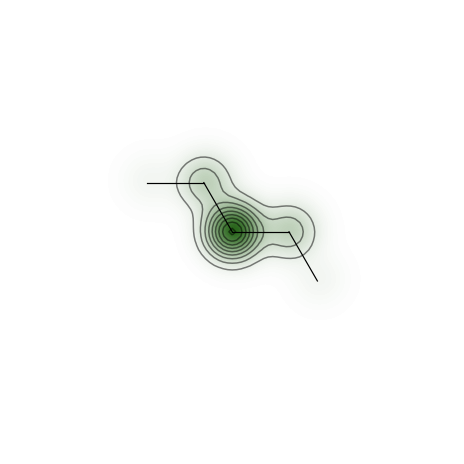

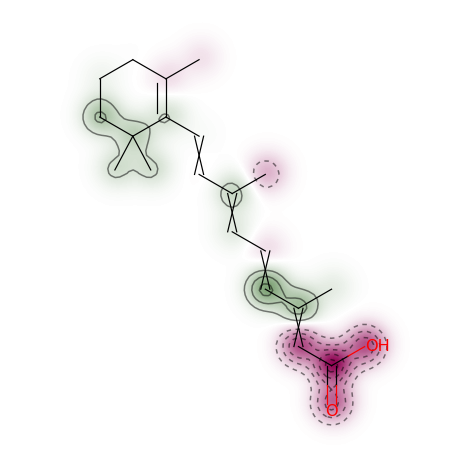

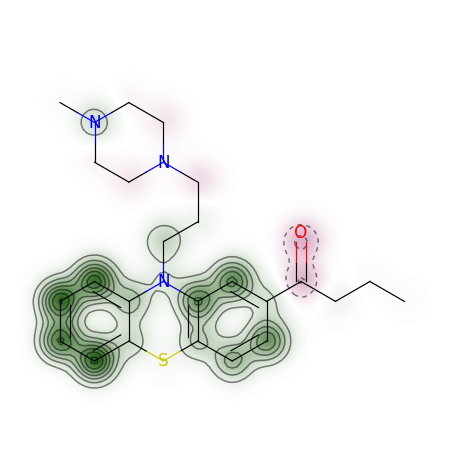

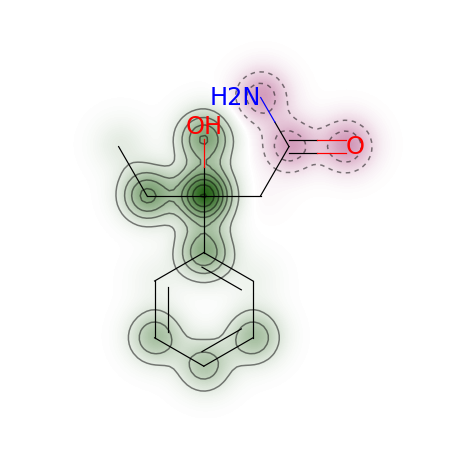

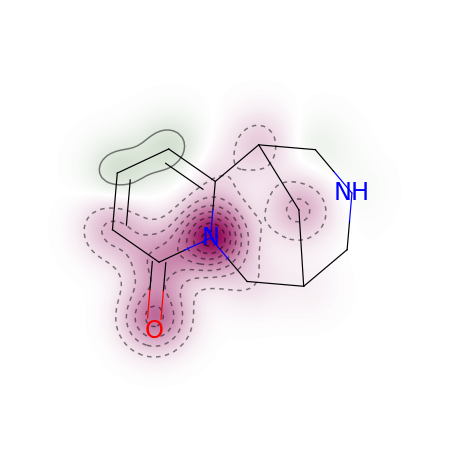

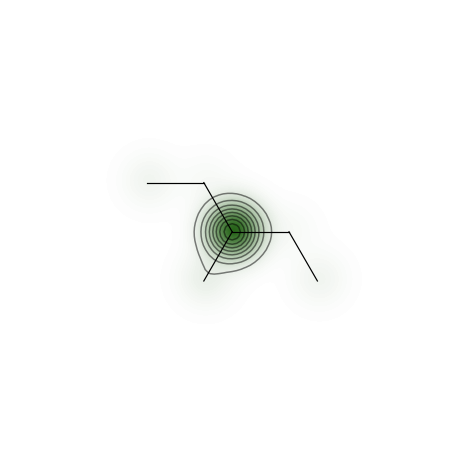

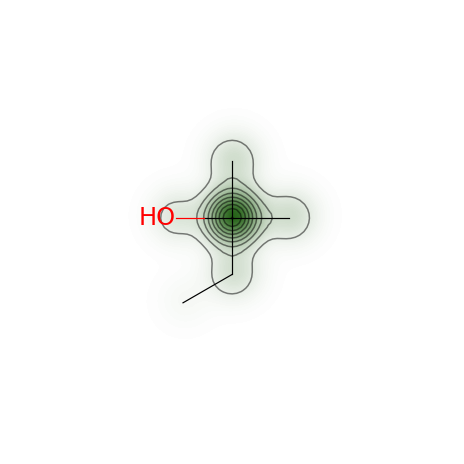

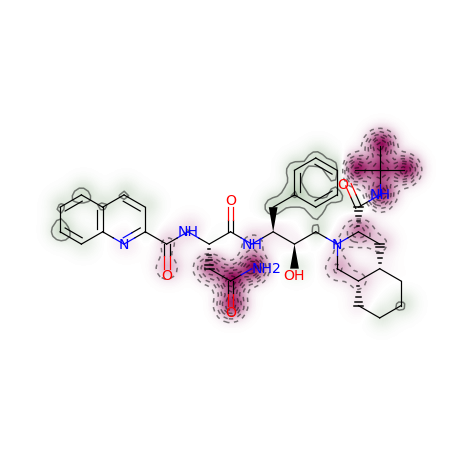

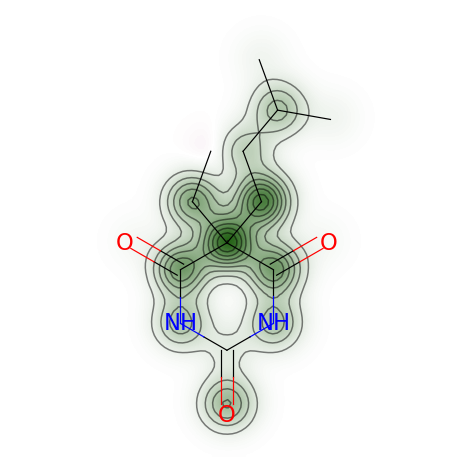

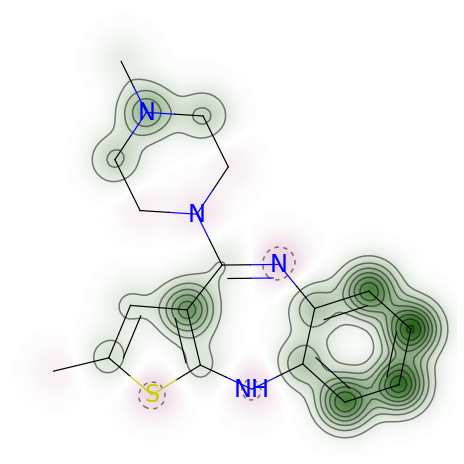

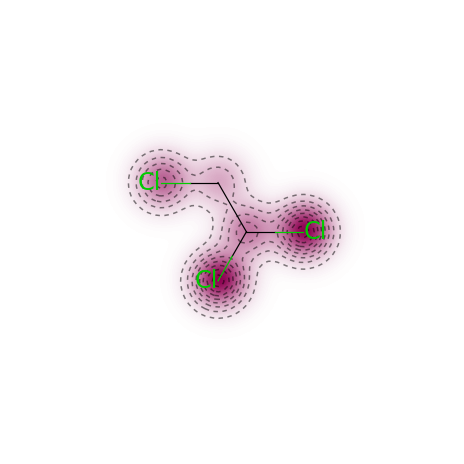

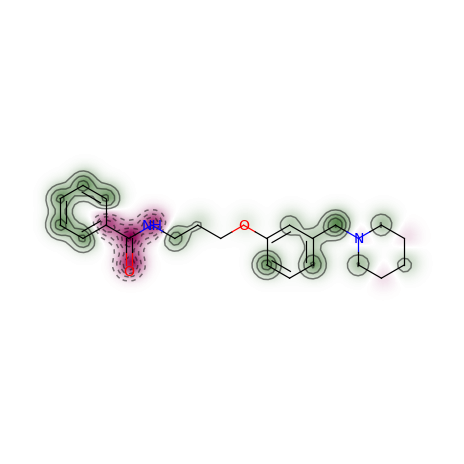

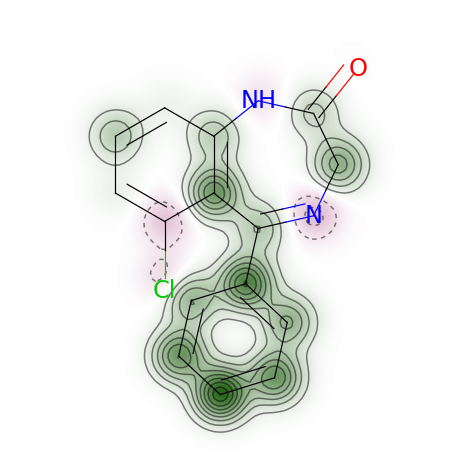

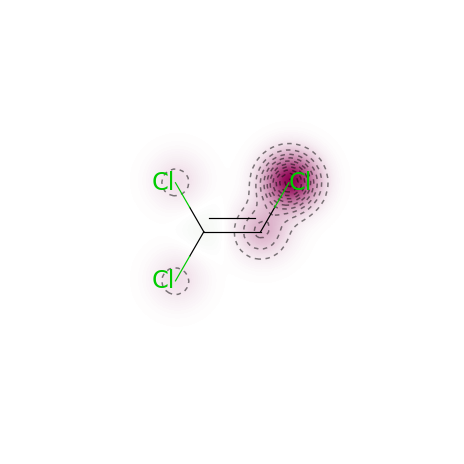

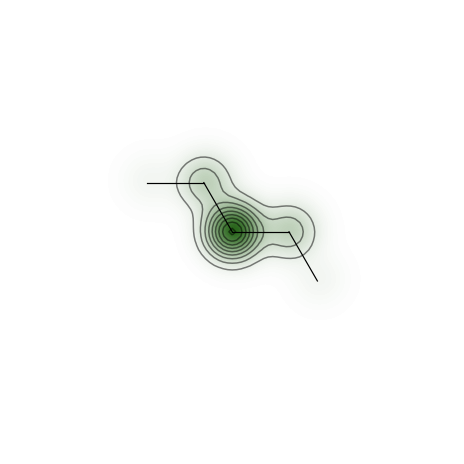

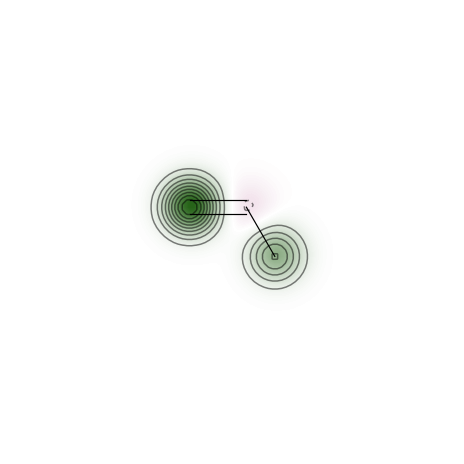

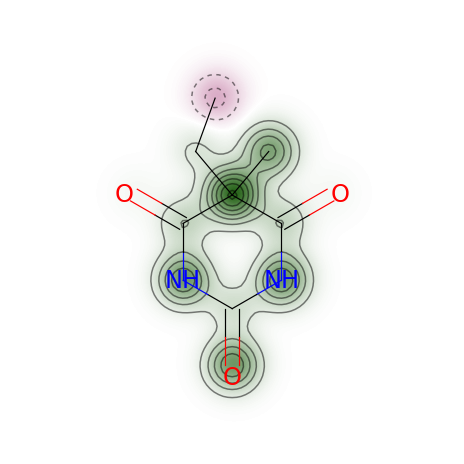

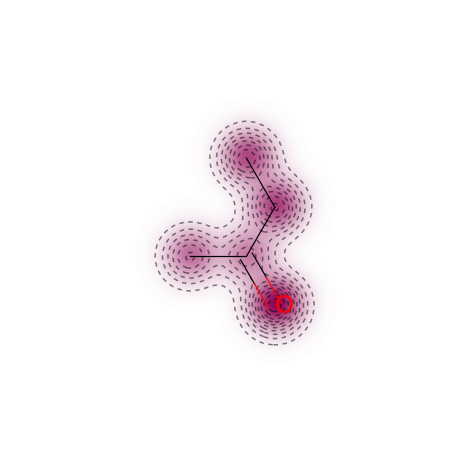

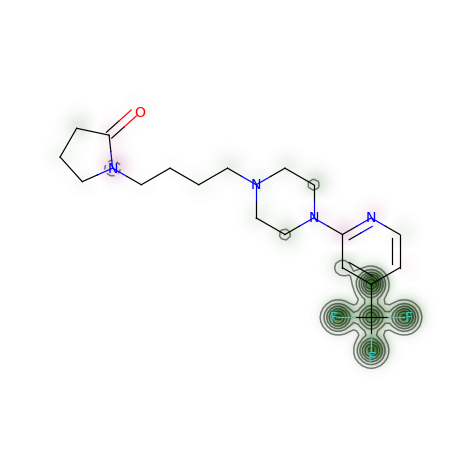

In [30]:
np.random.seed(2000)
maps = vis_contribs(np.random.choice(np.array(mols),20), df)

### We can see, that aromatics or aliphatics  have positive impact on membrane permeability, while polar or charged heteroatoms  have negative influence. This is generally consistent with literature data.

## 6. Let's take  a regression task, aquatic toxicity (towards water organism T. pyriformis).
### Toxicity is defined as log10 (IGC50) (concentration that inhibits colony growth by 50 %). Toxicophores for T. pyriformis will be identified by atomic ocntributions.
### All the above steps are the same: load data, featurize, build a model, create dataset of fragments, find contributions and visualize them
### Note: this time as it is regression, contributions will be in activity units, not probability


In [31]:
DATASET_FILE ='atomic_contributions_tutorial_data/Tetrahymena_pyriformis_Work_set_OCHEM.sdf'

In [32]:
# create RDKit mol objects, we will need them later
mols = [m for m in Chem.SDMolSupplier(DATASET_FILE) if m is not None ]

In [33]:
len(mols)

1424

In [34]:
loader = dc.data.SDFLoader(tasks=["IGC50"], 
                           featurizer=dc.feat.ConvMolFeaturizer(), sanitize = True)

dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

In [35]:
np.histogram(dataset.y)

(array([ 16,  79, 156, 233, 320, 275, 185, 104,  45,  11]),
 array([0.49, 1.077, 1.664, 2.251, 2.838, 3.425, 4.012, 4.599, 5.186,
        5.773, 6.36], dtype=object))

In [36]:
np.random.seed(2020)
tf.random.set_seed(2020)
m = dc.models.GraphConvModel(1, mode="regression", nb_epoch=40,batch_normalize=False, restore=False)
m.fit(dataset)

/home/maria/anaconda3/envs/deepchem_testing/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.3669636917114258

In [37]:
TEST_DATASET_FILE = 'atomic_contributions_tutorial_data/Tetrahymena_pyriformis_Test_set_OCHEM.sdf'
loader = dc.data.SDFLoader(tasks=["IGC50"], sanitize= True,
        
                           featurizer=dc.feat.ConvMolFeaturizer())

test_dataset = loader.create_dataset(TEST_DATASET_FILE, shard_size=2000)


In [38]:
pred = m.predict(test_dataset)

In [39]:
mse=metrics.mean_squared_error(y_true=test_dataset.y, y_pred=pred)
r2=metrics.r2_score(y_true=test_dataset.y, y_pred=pred)

In [40]:
mse

0.41432252518295415

In [41]:
r2 # r2 is not very high, but acceptable

0.6248392117899626

In [42]:
# load again the training set using standard Deepchem function, 
# but when featurizing it,  set per_atom_fragmentation=True

loader = dc.data.SDFLoader(tasks=[], # dont need any task
                           sanitize = True,
                           featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True)) 

frag_dataset = loader.create_dataset(DATASET_FILE, shard_size=5000)

/home/maria/anaconda3/envs/deepchem_testing/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [43]:
# whole molecules
pred = m.predict(dataset)
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convinience

In [44]:
# fragments
pred_frags = m.predict(frag_dataset)
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])  # turn to dataframe for convinience

In [45]:
# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]

In [46]:
df

,Fragment,Molecule,Contrib
BrC(Br)c1ccccc1,3.651596,3.952266,0.300670
BrC(Br)c1ccccc1,2.424250,3.952266,1.528015
BrC(Br)c1ccccc1,3.651596,3.952266,0.300670
BrC(Br)c1ccccc1,3.711324,3.952266,0.240942
BrC(Br)c1ccccc1,3.789643,3.952266,0.162622
...,...,...,...
c1csc(-c2cccs2)c1,3.498936,3.394323,-0.104612
c1csc(-c2cccs2)c1,3.536607,3.394323,-0.142283
c1csc(-c2cccs2)c1,3.473292,3.394323,-0.078969
c1csc(-c2cccs2)c1,3.500025,3.394323,-0.105701


In [305]:
# Lets take some mol with moderate activity (not extremely active/inactive)

In [ ]:
maps = vis_contribs([mol for mol in mols if float(mol.GetProp("IGC50"))>3 and float(mol.GetProp("IGC50"))<4], df)

/home/maria/anaconda3/envs/deepchem_testing/lib/python3.7/site-packages/rdkit/Chem/Draw/mplCanvas.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = figure(figsize=figsize)


### We can see, that known toxicophores are in green, namely, nitro-aromatics, halo-aromatics, long alkyl chains, aldehyde; while carboxylic group, alcohol, amino are detoxyfying, as is consistent with literature [3]

# Appendix

## In this tutorial we operated on sdf files. However,  If we use csv with SMILES as input , the order of atoms in the dataframe DOES NOT correspond to original atom order. If we  want to recover the original atom order for each molecule (to have it in our main dataframe), we need to use RDKit's  Chem.rdmolfiles.CanonicalRankAtoms. Here are some utils to do this.
## We can add a column with atom ids (as in input molecules) and use the resulting dataframe for analysis with any other  software, outside "python-rdkit-deepchem" environment

In [ ]:
def get_mapping(mols, mol_names): 
    """perform mapping:
    atom number original <-> atom number(position) 
    after ranking (both 1-based)"""
    # mols - RDKit mols
    # names  - any seq of strings
    # return list of nested lists: [[molecule, [atom , atom, ..], [...]]
    assert(len(mols)==len(mol_names))
    mapping = []
    for m,n in zip(mols, mol_names):
        atom_ids = [i+1 for i in list(
            Chem.rdmolfiles.CanonicalRankAtoms(m))]
        mapping.append([n, atom_ids
                   ])
    
    return mapping
    

In [ ]:
def append_atomid_col(df, mapping):
    # add column with CORRECT atom number(position)
    for i in mapping:
        df.loc[i[0],"AtomID"] = i[1]
    return df   

# Bibliography:

###### 1. Polishchuk, P., O. Tinkov, T. Khristova, L. Ognichenko, A. Kosinskaya, A. Varnek & V. Kuz’min (2016) Structural and Physico-Chemical Interpretation (SPCI) of QSAR Models and Its Comparison with Matched Molecular Pair Analysis. Journal of Chemical Information and Modeling, 56, 1455-1469.
###### 2. Riniker, S. & G. Landrum (2013) Similarity maps - a visualization strategy for molecular fingerprints and machine-learning methods. Journal of Cheminformatics, 5, 43.
###### 3. M. Matveieva, M. T. D. Cronin, P. Polishchuk, Mol. Inf. 2019, 38, 1800084. 